# Dark Current analysis

## Import needed packages

In [80]:
import pandas as pd
from astropy.io import fits
import seaborn as sns
from astropy.stats import sigma_clipped_stats
from scipy import stats

sns.set(style="ticks", color_codes=True)
%matplotlib inline

## Changeable parameters

### cooldown
Number of the cooldown using 3 numbers (add the 0 in front if necessary)

### R_dark_file & B_dark_file
The number of the dark file for each channel, using 4 numbers (add the 0 in front if necessary)

### swc_plot & lwc_plot
These are the paths and names for your result pictures. Just make sure to have any folders created, the code doesn't create folders, just adds the file there. If you are not sure, just put a name here and it saves the pictures to your working folder.

### length & i
These refer to the ramps in the dark files. you might need to play with them a bit. The normal file will have the ramp up twice, and you only want to use one of these ramps. You can use the observations from 0 - 9 (i=0, length=9) or the second ramp from 10 - 19 (i=10, length=19). These are defined separately for the swc and lwc.

### text and yoff
The last parameters here are for the texts that you end up plotting. You can look below where the plot is made and these parameters are used in sns_plot.text commands. These mark where the text is written. Depending on the data, it is possible you need to play around with these to make the plot look good. These are mostly cosmetic issues. It shouldn't be necessary to actually go into the sns_plot.text command to change things, just make sure if you do, that you only change the position values.

In [81]:
cooldown = '074'

B_dark_file = '0127'
R_dark_file = '0123'

swc_plot='Cooldown_results/Cooldown_74/LB074_swc_dark.png'
lwc_plot='Cooldown_results/Cooldown_74/LB074_lwc_dark.png'

swc_length =10
swc_i = 0

lwc_length = 19 
lwc_i = 10

swc_text_y= 0.03
swc_yoff=0.005

lwc_text_y= 1.3
lwc_yoff=0.05

## Open the files for swc and lwc

Here we open both dark files and print the info, to make sure we have the correct files and dimensions (256, 256, 20).

In [82]:
swc_path = 'LB'+cooldown+'/B/bLB'
lwc_path = 'LB'+cooldown+'/R/rLB'

swc_file = swc_path+cooldown+'_'+B_dark_file+'.fits'
lwc_file = lwc_path+cooldown+'_'+R_dark_file+'.fits'

#print(swc_file)

fits.info(swc_file)
fits.info(lwc_file)

swc_fits = fits.open(swc_file)
lwc_fits = fits.open(lwc_file)

Filename: LB074/B/bLB074_0127.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     316   (256, 256, 20)   float32   
Filename: LB074/R/rLB074_0123.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     316   (256, 256, 20)   float32   


## Get data for handling

We extract the needed information from thea headers and determine the PA offset: 1222 for SWC low-cap, 1280 for SWC hi-cap, 1370 for LWC low-cap, and 1000 for LWC hi-cap

In [83]:
#swc_fits[0].data[0] (to data[19])
swc = swc_fits[0]
lwc = lwc_fits[0]

swc_eperadu = float(swc.header['EPERADU'])
lwc_eperadu = float(lwc.header['EPERADU'])

swc_frmtime = float(swc.header['FRMTIME'])
lwc_frmtime = float(lwc.header['FRMTIME'])


swc_cap = swc.header['ILOWCAP']
lwc_cap = lwc.header['ILOWCAP']

PA_offset_swc = 0.
PA_offset_lwc = 0.
    
#1222 for SWC low-cap, 1280 for SWC hi-cap, 1370 for LWC low-cap, and 1000 for LWC hi-cap
if swc_cap == True:
    PA_offset_swc = 1222.
else:
    PA_offset_swc = 1280.

if lwc_cap == True:
    PA_offset_lwc = 1370.
else:
    PA_offset_lwc = 1000.
    

## Calculating dark values and creating arrays for plotting  (SWC)

Here we loop over the layers defined with swc_i & swc_length in the parameter part. We take the mean from the sigma clipped data (anything over 2.0 sigma is excluded) and deduct the PA offset and multiplying it with eperadu (electrons per count).

After we create a timing array for each of the ramp points from the frame time values and add these to another array.

In [84]:
dc_swc = []
fr_swc=[]

while swc_i < swc_length:
    data = swc.data[swc_i]
    mean, median, std = sigma_clipped_stats(data, sigma=2.0)
    dc_swc.append(((mean-PA_offset_swc)*swc_eperadu)/(10**6))
    swc_i += 1
    
for j, layer in enumerate(dc_swc):
    if j == 0:
        fr_swc.append(swc_frmtime/(10**3))
    else:
        fr_swc.append(swc_frmtime/(10**3)+fr_swc[j-1])

## Plotting the SWC data

Here we set the style values and plot the data. There might be some issues with new cooldowns on where to plot the texts. Here are some helpful points:
* For the red box with the Idark value we take the first data point and use the x time value as the x, the y value is the y value of the last point of the data. This should work most of the time with SWC.
* The lower texts start at half point (x = 0.5 sec mark). Y is defined for the upper row in the swc_text_y (above where you define parameters). The second row uses the same Y but deducts the swc_yoff value you set. 

Especially the lower texts might need some playing around, this might change when we have proper instructions on data taking and we always have good time values and get reasonable counts.

After the figure is created, it's saved with the path & name you defined above.

Text(0.1002701, 0.1076999970703125, '$Idark \\approx 0.10 \\, Me^-/s$ ')

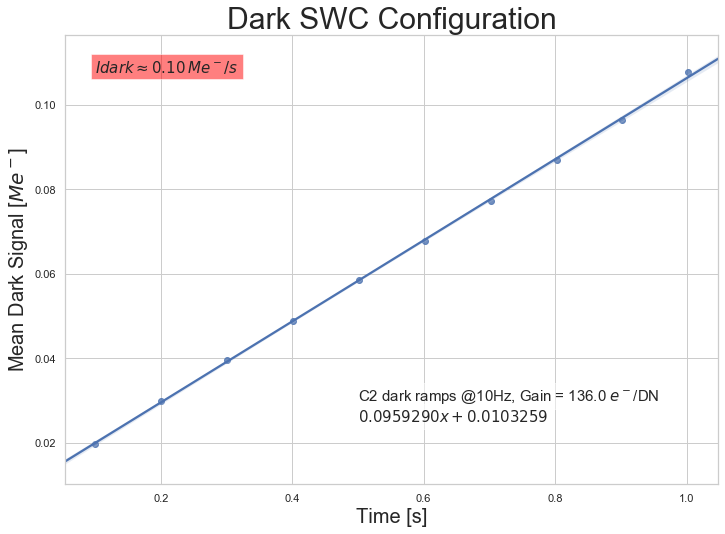

In [85]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
slope, intercept, r_value, p_value, std_err = stats.linregress(fr_swc,dc_swc)

sns_plot = sns.regplot(x=fr_swc, y=dc_swc)

sns_plot.set_title('Dark SWC Configuration',fontsize=30)
sns_plot.set_xlabel('Time [s]',fontsize=20)
sns_plot.set_ylabel('Mean Dark Signal [$Me^-$]',fontsize=20)

#print(slope, intercept)
sns_plot.text(0.5,swc_text_y, 'C2 dark ramps @10Hz, Gain = %.1f $e^-$/DN'%(swc_eperadu), bbox=dict(facecolor='white', alpha=0.5), fontsize =15)
sns_plot.text(0.5,swc_text_y-swc_yoff, '$%.7fx %+.7f$'%(slope, intercept), bbox=dict(facecolor='white', alpha=0.5), fontsize =15)
sns_plot.text(fr_swc[0],dc_swc[9], r'$Idark \approx %.2f \, Me^-/s$ '%(slope), bbox=dict(facecolor='red', alpha=0.5), fontsize =15)

In [86]:
fig = sns_plot.get_figure()
fig.savefig(swc_plot, bbox_inches='tight')

### Calculating dark values and creating arrays for plotting  (LWC)

Here we loop over the layers defined with lwc_i & lwc_length in the parameter part. We take the mean from the sigma clipped data (anything over 2.0 sigma is excluded) and deduct the PA offset and multiplying it with eperadu (electrons per count).

After we create a timing array for each of the ramp points from the frame time values and add these to another array.

In [87]:
dc_lwc = []
fr_lwc=[]

while lwc_i < lwc_length:
    data = lwc.data[lwc_i]
    mean, median, std = sigma_clipped_stats(data, sigma=2.0)
    dc_lwc.append(((mean-PA_offset_lwc)*swc_eperadu)/(10**6))
    lwc_i += 1
    
for j, layer in enumerate(dc_lwc):
    if j == 0:
        fr_lwc.append(lwc_frmtime/(10**3))
    else:
        fr_lwc.append(lwc_frmtime/(10**3)+fr_lwc[j-1])

## Plotting the LWC data

Here we set the style values and plot the data. There might be some issues with new cooldowns on where to plot the texts. Here are some helpful points:
* For the red box with the Idark value we take the first data point and use the x time value as the x, the y value is the y value right now takes the 7th value and adds 0.3 to it. This might need to be changed when our data taking procedure is stabilized.
* The lower texts start at half point (x = 0.5 sec mark). Y is defined for the upper row in the lwc_text_y (above where you define parameters). The second row uses the same Y but deducts the lwc_yoff value you set. 

For the LWC, all text placing, but especially the lower texts might need some playing around, this might change when we have proper instructions on data taking and we always have good time values and get reasonable counts.

After the figure is created, it's saved with the path & name you defined above.

Text(0.1002701, 2.0094956953125, '$Idark \\approx 0.52 \\, Me^-/s$ ')

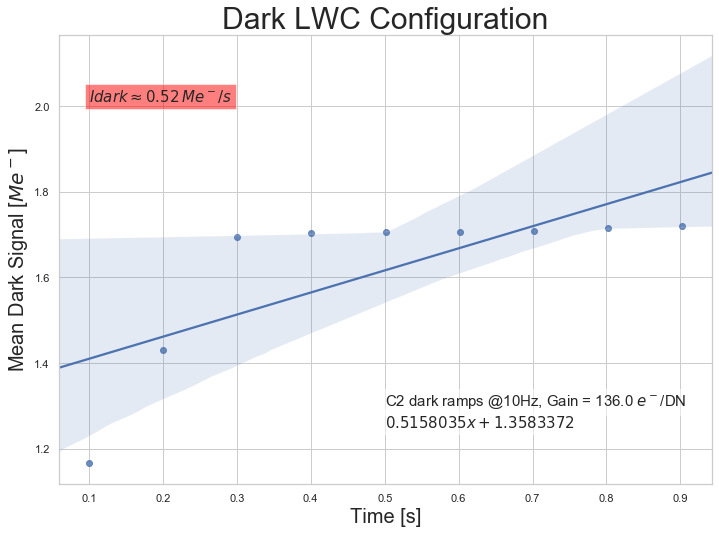

In [88]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
slope, intercept, r_value, p_value, std_err = stats.linregress(fr_lwc,dc_lwc)


sns_plot = sns.regplot(x=fr_lwc, y=dc_lwc)

sns_plot.set_title('Dark LWC Configuration',fontsize=30)
sns_plot.set_xlabel('Time [s]',fontsize=20)
sns_plot.set_ylabel('Mean Dark Signal [$Me^-$]',fontsize=20)

sns_plot.text(0.5,lwc_text_y, 'C2 dark ramps @10Hz, Gain = %.1f $e^-$/DN'%(lwc_eperadu), bbox=dict(facecolor='white', alpha=0.5), fontsize =15)
sns_plot.text(0.5,lwc_text_y-lwc_yoff, '$%.7fx %+.7f$'%(slope, intercept), bbox=dict(facecolor='white', alpha=0.5), fontsize =15)
sns_plot.text(fr_lwc[0],dc_lwc[6]+0.3, r'$Idark \approx %.2f \, Me^-/s$ '%(slope), bbox=dict(facecolor='red', alpha=0.5), fontsize =15)

In [89]:
fig = sns_plot.get_figure()
fig.savefig(lwc_plot, bbox_inches='tight')